<a href="https://colab.research.google.com/github/fboreiko/anomalies_detection/blob/main/PyroFirstTask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyro-ppl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.5/732.5 kB 11.6 MB/s eta 0:00:00


A simple program aimed to learn Pyro Normalizing Flows. Samples data from a predefined PDF and applies a Spline model to fit the PDF.


In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T
from pyro.nn import AutoRegressiveNN
from pyro.nn.dense_nn import DenseNN
from pyro.params.param_store import ParamStoreDict
from pyro.nn.module import PyroModule
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from scipy import stats
import math
import tqdm
import itertools
smoke_test = ('CI' in os.environ)

Creating a mix of lognormal and laplace distributions

In [ ]:
def CreateDist(loc1, loc2, loc3, loc4, scale1, scale2, scale3, scale4, size1, size2, size3, size4):
    x = np.concatenate([np.random.lognormal(loc1, scale1, size1),
                        np.random.normal(loc2, scale2, size2),
                        np.random.normal(loc3, scale3, size3),
                        np.random.laplace(loc4, scale4, size4)])
    x = np.random.permutation(x)
    return x

['pupa', 'pipa', 'pipa']


Function that splits data on training, validation and test sets

In [ ]:
def DataSplit(data, val_size, test_size):
    train_set = data[:np.size(data)-val_size-test_size]
    val_set = data[np.size(data)-val_size-test_size:np.size(data)-test_size]
    test_set = data[np.size(data)-test_size:]
    return train_set, val_set, test_set

Sampling and plotting

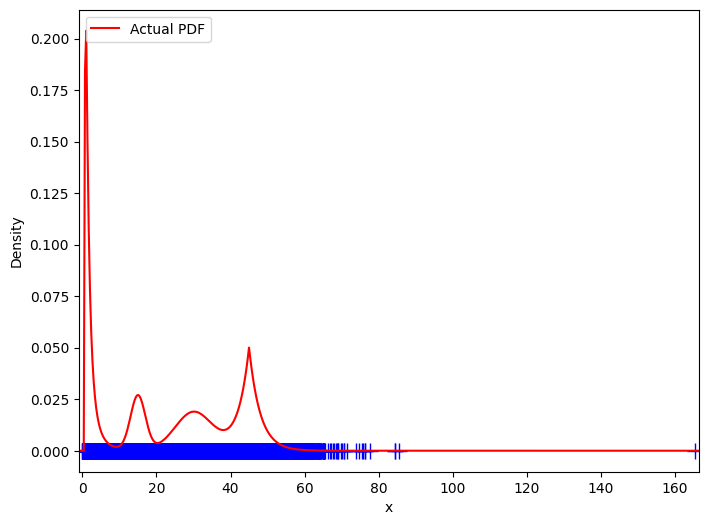

In [ ]:
loc1, scale1, size1 = (0.5, 1, 50000)
loc2, scale2, size2 = (15, 2, 20000)
loc3, scale3, size3 = (30, 5, 35000)
loc4, scale4, size4 = (45, 3, 45000)
s = 1

samples = CreateDist(loc1, loc2, loc3, loc4, scale1, scale2, scale3, scale4, size1, size2, size3, size4)

x_eval = np.linspace(samples.min() - 1, samples.max() + 1, 500)

dist_pdf = stats.lognorm.pdf(x_eval, s, loc=loc1, scale=scale1) * float(size1) / samples.size + \
           stats.norm.pdf(x_eval, loc=loc2, scale=scale2) * float(size2) / samples.size + \
           stats.norm.pdf(x_eval, loc=loc3, scale=scale3) * float(size3) / samples.size + \
           stats.laplace.pdf(x_eval, loc=loc4, scale=scale4) * float(size4) / samples.size

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.plot(samples, np.zeros(samples.shape), 'b+', ms=12)
ax.plot(x_eval, dist_pdf, 'r-', label="Actual PDF")

ax.set_xlim([x_eval.min(), x_eval.max()])
ax.legend(loc=2)
ax.set_xlabel('x')
ax.set_ylabel('Density')
plt.show()

Learning the marginals of the above distribution using such a transform, Spline, defined on a one-dimensional input:

In [ ]:
base_dist = dist.Normal(torch.zeros(1), torch.ones(1))
spline_transform = T.Spline(1, count_bins=64, bound=64)
pyro.module("my_transform", spline_transform)
bn_transforms = T.BatchNorm(1)
flow_dist = dist.TransformedDistribution(base_dist, [bn_transforms, spline_transform])


Encoding changeable parameters:

In [ ]:
num_epochs = 200
batch_size = 128
val_size = 25000
test_size = 25000

The knots of the spline and their derivatives are parameters that can be learnt, e.g., through minibatch stochastic gradient descent on a maximum likelihood objective

Average loss: 3.66, BV loss: 3.668394, BV epoch: 197: 100%|██████████| 200/200 [13:56<00:00,  4.18s/it]


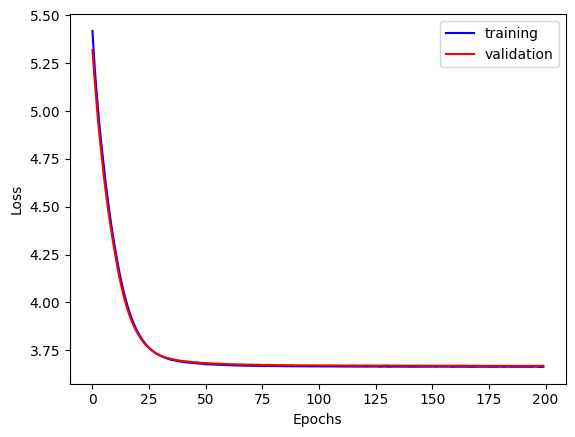

In [ ]:
losses = []
validation_losses = []

data_size = samples.size
samples = samples.reshape(data_size, 1)
train_set, val_set, test_set = DataSplit(samples, val_size, test_size)
dataset = torch.tensor(train_set, dtype=torch.float64)
valset = torch.tensor(val_set, dtype=torch.float64)
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

train_size = train_set.size
num_batches = train_size // batch_size

#pyro.module("nf", nn.ModuleList(spline_transforms))
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=1e-4)
epochs = tqdm.trange(num_epochs)
best_val_loss = 1e7
best_val_epoch = 0
for epoch in epochs:
    try:
        running_loss = 0
        for i, inputs in enumerate(dataloader):
            optimizer.zero_grad()
            loss = -flow_dist.log_prob(inputs).mean()   #split to batches (!)
            running_loss += loss
            loss.backward()
            optimizer.step()
            flow_dist.clear_cache()
        average_loss = running_loss.item()/(num_batches)
        losses.append(average_loss)

    except KeyboardInterrupt:
        plt.plot(losses);
        break

    with torch.no_grad():
        val_loss = -flow_dist.log_prob(valset).mean()
        item = val_loss.item()
        validation_losses.append(item)
        flow_dist.clear_cache()
        if item < best_val_loss:
            pyro.get_param_store().save('/content/trained_model')
            best_val_loss = validation_losses[epoch]
            best_val_epoch = epoch

    epochs.set_description("Average loss: {:.2f}, BV loss: {:f}, BV epoch: {:.0f}".format(average_loss, best_val_loss, best_val_epoch))

plt.plot(losses, 'b', label='training')
plt.plot(validation_losses, 'r', label='validation')
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()



In [ ]:
!ls -l

total 8
drwxr-xr-x 1 root root 4096 Jul  5 13:38 sample_data
-rw-r--r-- 1 root root 2655 Jul  7 00:42 trained_model


Sanity check:

In [ ]:
with torch.no_grad():
    pre_loaded = -flow_dist.log_prob(valset).mean()
    print(pre_loaded.item())

base_dist_pt = dist.Normal(torch.zeros(1), torch.ones(1))
spline_transform_pt = T.Spline(1, count_bins=64, bound=64)
pyro.get_param_store().load('/content/trained_model')
pyro.module("my_transform_pt", spline_transform_pt, update_module_params=True)
bn_transform_pt = T.BatchNorm(1)
flow_dist_pt = dist.TransformedDistribution(base_dist, [bn_transform_pt, spline_transform_pt])

with torch.no_grad():
    loaded = -flow_dist.log_prob(valset).mean()
    print(loaded.item())

3.6684080510927424
3.6684080510927424


Drawning samples from the transformed distribution after learning:

In [ ]:
samples_flow = flow_dist.sample(torch.Size([test_size])).detach().numpy()

Creating a pd.Dataframe of samples and samples_flow:

In [ ]:
data = np.concatenate((test_set, samples_flow), axis=1)
columns = ['test_set', 'sample_flow']
df = pd.DataFrame(data,columns=columns)

Plotting samples and samples_flow:

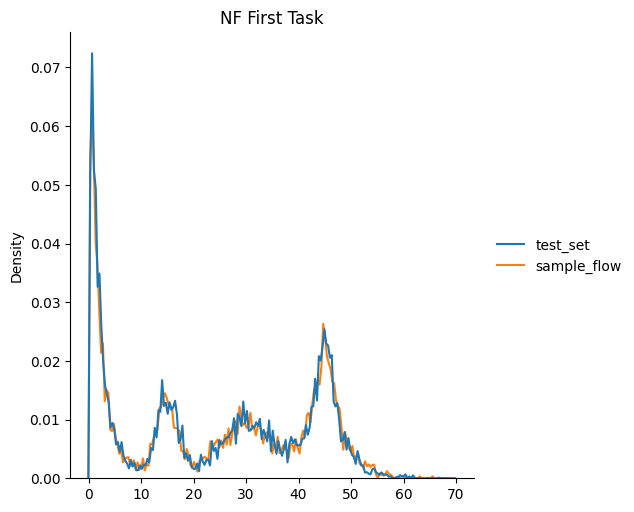

In [ ]:
sns.displot(df, kind='kde', bw_adjust=0.05, label='data') #log_scale=True
plt.title("NF First Task")
plt.show()